In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

In [2]:
# Carregar dados do CPU
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


In [3]:
# split data in train (75%) test (24%) validation (1%)
df = workload
df_len = len(df)
train_len = int(df_len * 0.75)
test_len = int(df_len * 0.24)
validation_len = df_len - train_len - test_len

In [4]:
workload_len = len(workload)
features_len = 60

In [5]:
features = []
labels = []
for pos in range(features_len, workload_len):
    features.append(np.array(workload['cpu'][pos-features_len:pos]))
    labels.append(np.array(workload['cpu'][pos]))

In [6]:
# normalize feature datas
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)
print(features_scale.shape)
print(features_scale[-1])

(11460, 60)
[0.17333333 0.13333333 0.17333333 0.30666667 0.38666667 0.34666667
 0.17333333 0.21333333 0.18666667 0.14666667 0.18666667 0.13333333
 0.17333333 0.14666667 0.14666667 0.17333333 0.14666667 0.16
 0.49333333 0.34666667 0.36       0.29333333 0.28       0.25333333
 0.26666667 0.2        0.14666667 0.13333333 0.16       0.13333333
 0.08       0.14666667 0.14666667 0.13333333 0.13333333 0.09333333
 0.08       0.10666667 0.10666667 0.2        0.14666667 0.13333333
 0.17333333 0.12       0.12       0.08       0.05333333 0.04
 0.06666667 0.06666667 0.09333333 0.05333333 0.08       0.14666667
 0.17333333 0.2        0.13333333 0.08       0.14666667 0.10666667]


In [7]:
# split data in train (75%) test (24%) validation (1%)
df = workload
# reset index
df.reset_index(inplace=True)
df_len = len(df)
train_len = int(df_len * 0.75)
test_len = int(df_len * 0.24)
validation_len = df_len - train_len - test_len
train_len, test_len, validation_len

(8640, 2764, 116)

In [8]:
# split train and test datasets
X_train = features_scale[:train_len]
X_test = features_scale[train_len:-validation_len]

y_train = np.array(labels[:train_len])
y_test = np.array(labels[train_len:-validation_len])

# show datasets shapes
for x in [X_train, X_test, y_train, y_test]:
    print(x.shape)

(8640, 60)
(2704, 60)
(8640,)
(2704,)


In [9]:
# neurak network with parameters search

nn = MLPRegressor()

parameter_space = {
    'hidden_layer_sizes': [(x,) for x in range(1,21)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

search = GridSearchCV(nn, parameter_space, n_jobs=-1, cv=5)
search.fit(X_train, y_train)
pred = search.predict(X_test)

In [10]:
# best parameters
search.best_estimator_

MLPRegressor(alpha=0.05, hidden_layer_sizes=(17,))

In [11]:
# validate predict with test set
rmse = mean_squared_error(y_test, pred)
print(f'root_mean_squared_error: {rmse}')
mse = mean_squared_error(y_test, pred, squared=False)
print(f'mean_squared_error: {mse}')
cd = r2_score(y_test, pred)
print(f'Determination coeficient: {cd}')
ev = explained_variance_score(y_test, pred)
print(f'explained_variance_score: {ev}')
me = max_error(y_test, pred)
print(f'max_error: {me}')
mae = mean_absolute_error(y_test, pred)
print(f'mean_absolute_error: {mae}')

root_mean_squared_error: 38.87890901728495
mean_squared_error: 6.235295423416997
Determination coeficient: 0.6623141122941016
explained_variance_score: 0.6627975314124374
max_error: 38.45675274717579
mean_absolute_error: 4.721988507208363


<AxesSubplot:>

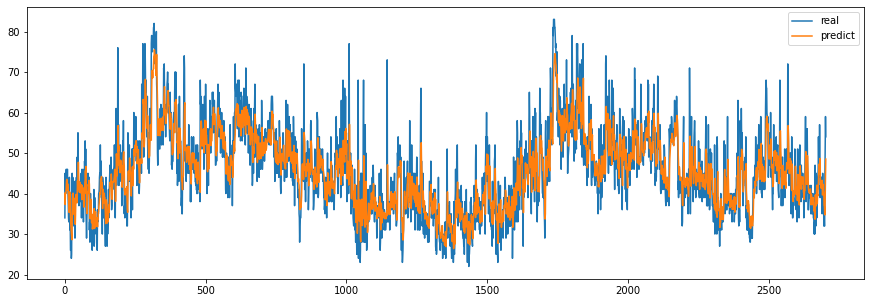

In [12]:
plot_df = pd.DataFrame({'real':y_test, 'predict':pred})
plot_df.plot(figsize=(15,5))

In [13]:
# predict execution
predict = features_scale[-validation_len:]
exchange_date_full = df['time_stamp']
exchange_date = exchange_date_full[-validation_len:]
close_full = df['cpu']
close = close_full[-validation_len:]

pred = search.predict(predict)

val_df = pd.DataFrame({'date':exchange_date, 'real':close, 'predict':pred})
val_df['real'] = val_df['real'].shift(+1)
val_df.dropna(inplace=True)

val_df.set_index('date', inplace=True)
val_df

,real,predict
date,,
1970-01-08 22:05:00,52.0,48.476263
1970-01-08 22:06:00,54.0,49.204889
1970-01-08 22:07:00,53.5,50.071245
1970-01-08 22:08:00,53.0,49.396478
1970-01-08 22:09:00,46.0,47.882108
...,...,...
1970-01-08 23:55:00,30.0,27.381568
1970-01-08 23:56:00,25.0,26.161165
1970-01-08 23:57:00,21.0,23.425262


<AxesSubplot:xlabel='date'>

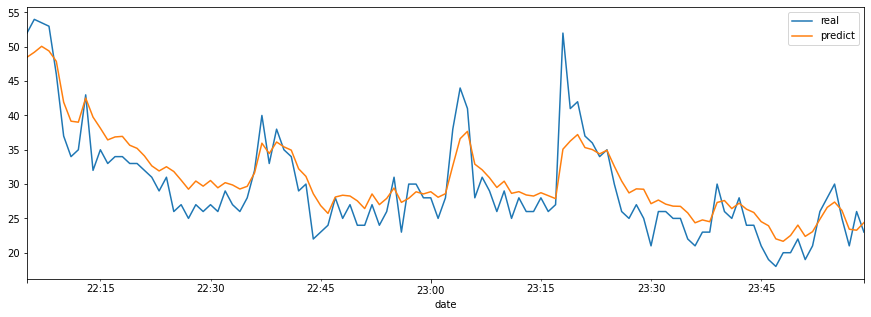

In [14]:
val_df.plot(figsize=(15,5))

In [15]:
# validate predict with validation set
rmse = mean_squared_error(val_df['real'], val_df['predict'])
print(f'root_mean_squared_error: {rmse}')
mse = mean_squared_error(val_df['real'], val_df['predict'], squared=False)
print(f'mean_squared_error: {mse}')
cd = r2_score(val_df['real'], val_df['predict'])
print(f'Determination coeficient: {cd}')
ev = explained_variance_score(val_df['real'], val_df['predict'])
print(f'explained_variance_score: {ev}')
me = max_error(val_df['real'], val_df['predict'])
print(f'max_error: {me}')
mae = mean_absolute_error(val_df['real'], val_df['predict'])
print(f'mean_absolute_error: {mae}')

root_mean_squared_error: 11.7876904756525
mean_squared_error: 3.4333206194080534
Determination coeficient: 0.7899087741520908
explained_variance_score: 0.8209129167484917
max_error: 16.917957468209067
mean_absolute_error: 2.768774628641176
